In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import lightgbm as lgb
from sklearn.feature_selection import RFE
import math

In [2]:
train=pd.read_csv('train.csv', sep=',')
train_index=train.index
test=pd.read_csv('test.csv', sep=',')
test['is_pass']=0
dataset=train.append(test)
dataset.isnull().sum()

id                               0
program_id                       0
program_type                     0
program_duration                 0
test_id                          0
test_type                        0
difficulty_level                 0
trainee_id                       0
gender                           0
education                        0
city_tier                        0
age                          39520
total_programs_enrolled          0
is_handicapped                   0
trainee_engagement_rating      108
is_pass                          0
dtype: int64

In [3]:
print(train.groupby('is_pass')['is_pass'].count())

is_pass
0    22280
1    50867
Name: is_pass, dtype: int64


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104496 entries, 0 to 31348
Data columns (total 16 columns):
id                           104496 non-null object
program_id                   104496 non-null object
program_type                 104496 non-null object
program_duration             104496 non-null int64
test_id                      104496 non-null int64
test_type                    104496 non-null object
difficulty_level             104496 non-null object
trainee_id                   104496 non-null int64
gender                       104496 non-null object
education                    104496 non-null object
city_tier                    104496 non-null int64
age                          64976 non-null float64
total_programs_enrolled      104496 non-null int64
is_handicapped               104496 non-null object
trainee_engagement_rating    104388 non-null float64
is_pass                      104496 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 13.6+ MB


In [5]:
dataset.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,Matriculation,1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,Matriculation,3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School Diploma,1,42.0,2,N,4.0,1


In [6]:
dataset.describe()

,program_duration,test_id,trainee_id,city_tier,age,total_programs_enrolled,trainee_engagement_rating,is_pass
count,104496.000000,104496.000000,104496.000000,104496.000000,64976.000000,104496.000000,104388.000000,104496.000000
mean,128.209386,90.937672,9846.168045,2.248478,36.478038,2.586223,2.397776,0.486784
std,6.892792,51.219793,5706.697072,1.011789,9.045325,1.238415,1.327130,0.499828
min,117.000000,0.000000,1.000000,1.000000,17.000000,1.000000,1.000000,0.000000
25%,121.000000,45.000000,5041.000000,1.000000,28.000000,2.000000,1.000000,0.000000
50%,131.000000,90.000000,9648.500000,2.000000,39.000000,2.000000,2.000000,0.000000
75%,134.000000,135.000000,14555.250000,3.000000,45.000000,3.000000,4.000000,1.000000
max,136.000000,187.000000,20098.000000,4.000000,63.000000,14.000000,5.000000,1.000000


In [7]:
print(train.groupby(['is_pass', 'trainee_engagement_rating'])['is_pass'].count())
print(dataset['id'].groupby(by=dataset['trainee_engagement_rating']).count())

is_pass  trainee_engagement_rating
0        1.0                          10455
         2.0                           5426
         3.0                           3028
         4.0                           2565
         5.0                            767
1        1.0                          15140
         2.0                          11808
         3.0                           8525
         4.0                          10548
         5.0                           4808
Name: is_pass, dtype: int64
trainee_engagement_rating
1.0    36547
2.0    24636
3.0    16352
4.0    18841
5.0     8012
Name: id, dtype: int64


In [8]:
dataset['rating_given']=dataset['trainee_engagement_rating'].apply(lambda x:0 if math.isnan(x) == True else 1)
dataset['trainee_engagement_rating'].fillna(dataset['trainee_engagement_rating'].mode().iloc[0],inplace=True)
print(train.groupby(['is_pass', 'trainee_engagement_rating'])['is_pass'].count())
print(dataset['id'].groupby(by=dataset['trainee_engagement_rating']).count())

is_pass  trainee_engagement_rating
0        1.0                          10455
         2.0                           5426
         3.0                           3028
         4.0                           2565
         5.0                            767
1        1.0                          15140
         2.0                          11808
         3.0                           8525
         4.0                          10548
         5.0                           4808
Name: is_pass, dtype: int64
trainee_engagement_rating
1.0    36655
2.0    24636
3.0    16352
4.0    18841
5.0     8012
Name: id, dtype: int64


difficulty_level
easy            57211
hard            14777
intermediate    29537
vary hard        2971
Name: id, dtype: int64
is_pass  difficulty_level
0        easy                10539
         hard                 3423
         intermediate         7133
         vary hard            1185
1        easy                29562
         hard                 6874
         intermediate        13535
         vary hard             896
Name: is_pass, dtype: int64


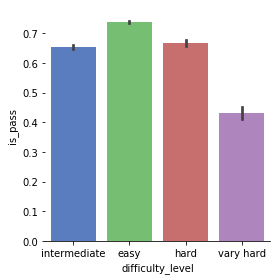

In [9]:
print(dataset['id'].groupby(by=dataset['difficulty_level']).count())
print(train.groupby(['is_pass', 'difficulty_level'])['is_pass'].count())
g = sns.factorplot(x='difficulty_level',y='is_pass', data=train, kind='bar', size = 4 , palette = 'muted')
g.despine(left=True)

In [10]:
dataset['difficulty_level'] = dataset['difficulty_level'].map({'easy':1, 'intermediate':2, 'hard' : 3, 'vary hard':4})
dataset['is_4']=dataset['difficulty_level'].apply(lambda x: 1 if x==4 else 0 )

test_type
offline    62256
online     42240
Name: id, dtype: int64
is_pass  test_type
0        offline      15767
         online        6513
1        offline      27776
         online       23091
Name: is_pass, dtype: int64


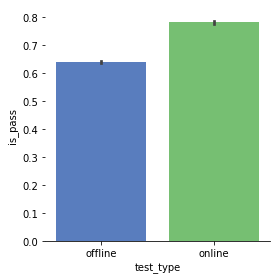

In [11]:
print(dataset['id'].groupby(by=dataset['test_type']).count())
print(train.groupby(['is_pass', 'test_type'])['is_pass'].count())
g = sns.factorplot(x='test_type',y='is_pass', data=train, kind='bar', size = 4 , palette = 'muted')
g.despine(left=True)

In [12]:
dataset['is_online']=dataset['test_type'].apply(lambda x: 0 if x=='offline' else 1)

education
Bachelors              16590
High School Diploma    48983
Masters                  754
Matriculation          37432
No Qualification         737
Name: id, dtype: int64
is_pass  education          
0        Bachelors               2982
         High School Diploma     9803
         Masters                   85
         Matriculation           9196
         No Qualification         214
1        Bachelors               8599
         High School Diploma    24568
         Masters                  427
         Matriculation          16973
         No Qualification         300
Name: is_pass, dtype: int64


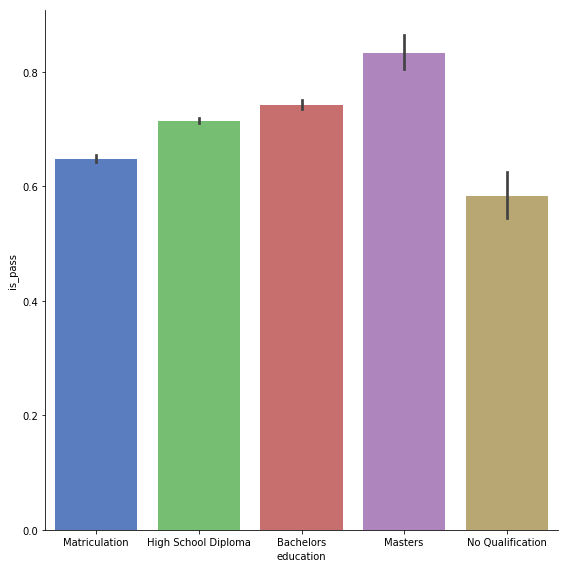

In [13]:
print(dataset['id'].groupby(by=dataset['education']).count())
print(train.groupby(['is_pass', 'education'])['is_pass'].count())
g = sns.factorplot(x='education',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

In [14]:
dataset['education'] = dataset['education'].map({'No Qualification':1, 'Matriculation':2, 'High School Diploma' : 3 , 'Bachelors':4, 'Masters':5})

gender
F    48623
M    55873
Name: id, dtype: int64
is_pass  gender
0        F         10730
         M         11550
1        F         23374
         M         27493
Name: is_pass, dtype: int64


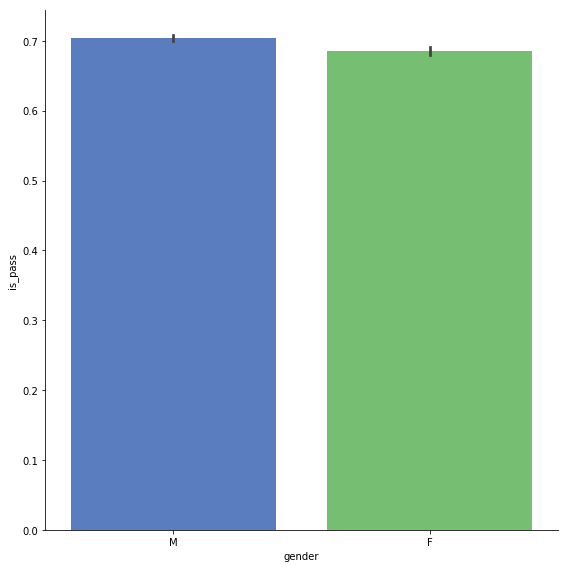

In [15]:
print(dataset['id'].groupby(by=dataset['gender']).count())
print(train.groupby(['is_pass', 'gender'])['is_pass'].count())
g = sns.factorplot(x='gender',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

In [16]:
gender=LabelEncoder()
dataset['gender']=gender.fit_transform(dataset['gender'])

is_handicapped
N    95247
Y     9249
Name: id, dtype: int64
is_pass  is_handicapped
0        N                 19923
         Y                  2357
1        N                 46654
         Y                  4213
Name: is_pass, dtype: int64


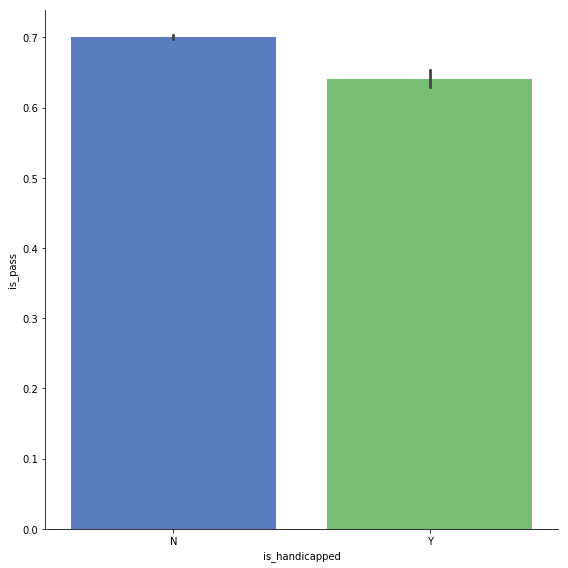

In [17]:
print(dataset['id'].groupby(by=dataset['is_handicapped']).count())
print(train.groupby(['is_pass', 'is_handicapped'])['is_pass'].count())
g = sns.factorplot(x='is_handicapped',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

In [18]:
dataset['is_handicapped']=dataset['is_handicapped'].apply(lambda x: 0 if x=='N' else 1)

program_id
S_1     946
S_2    1013
T_1    4521
T_2    6080
T_3    8919
T_4    6841
U_1    6792
U_2    4421
V_1    4856
V_2    2720
V_3    4859
V_4    6159
X_1    1911
X_2    1119
X_3    1698
Y_1    9521
Y_2    6056
Y_3    9589
Y_4    7138
Z_1    2669
Z_2    3016
Z_3    3652
Name: id, dtype: int64
is_pass  program_id
0        S_1            305
         S_2            297
         T_1           1559
         T_2           1107
         T_3           1660
         T_4           1235
         U_1           1694
         U_2           1237
         V_1           1320
         V_2            806
         V_3           1442
         V_4           1826
         X_1            217
         X_2            163
         X_3            239
         Y_1           1424
         Y_2           1069
         Y_3           1708
         Y_4           1121
         Z_1            561
         Z_2            583
         Z_3            707
1        S_1            339
         S_2            385
         T

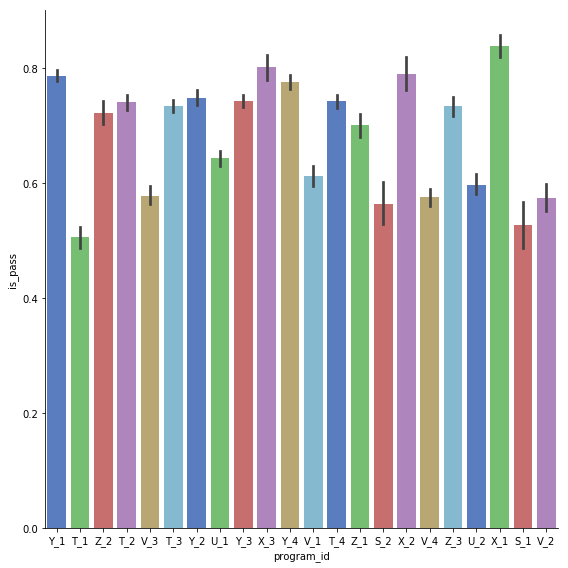

In [19]:
print(dataset['id'].groupby(by=dataset['program_id']).count())
print(train.groupby(['is_pass', 'program_id'])['is_pass'].count())
g = sns.factorplot(x='program_id',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

In [20]:
dummy_program_id=pd.get_dummies(dataset['program_id'])
dataset=pd.concat([dataset, dummy_program_id], axis=1)

In [21]:
dummy_program_type=pd.get_dummies(dataset['program_type'])
dataset=pd.concat([dataset, dummy_program_type], axis=1)

is_pass  program_duration
0        117                 1107
         120                 2887
         121                 2090
         122                 3063
         130                  707
         131                 3001
         133                 1320
         134                 3868
         135                 2013
         136                 2224
1        117                 3159
         120                 8243
         121                 5589
         122                 4311
         130                 1952
         131                 3570
         133                 2089
         134                 9159
         135                 5254
         136                 7541
Name: is_pass, dtype: int64


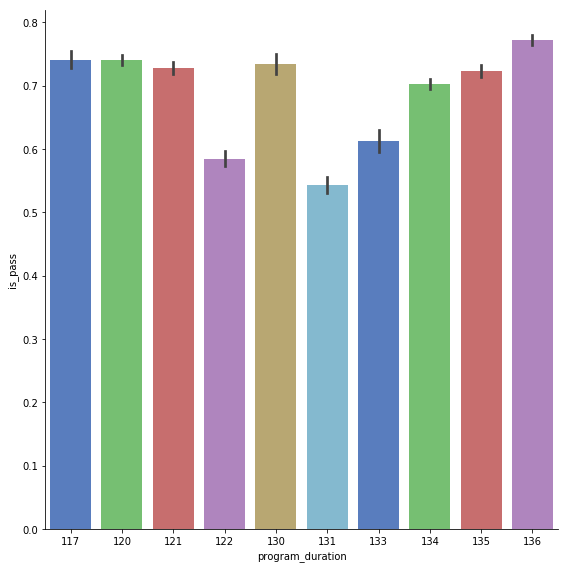

In [22]:
print(train.groupby(['is_pass', 'program_duration'])['is_pass'].count())
g = sns.factorplot(x='program_duration',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

is_pass  total_programs_enrolled
0        1                           2127
         2                          12234
         3                           2342
         4                           4122
         5                            634
         6                            517
         7                            101
         8                            119
         9                             46
         10                             9
         11                             6
         12                            19
         14                             4
1        1                           5395
         2                          28304
         3                           5310
         4                           9399
         5                           1071
         6                            941
         7                            185
         8                            181
         9                             33
         10                            21
 

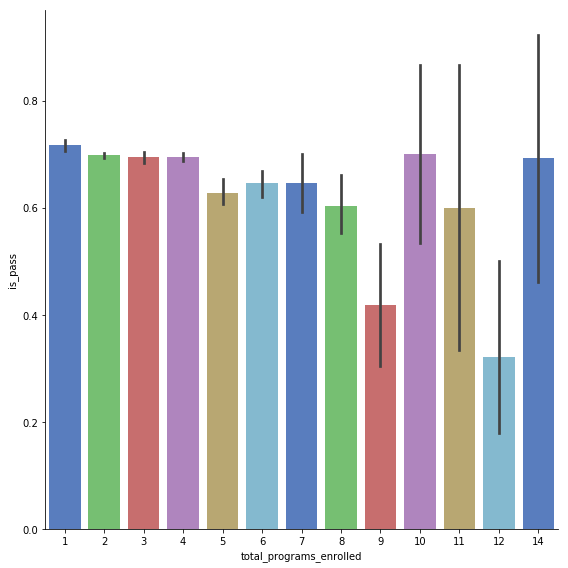

In [23]:
print(train.groupby(['is_pass', 'total_programs_enrolled'])['is_pass'].count())
g = sns.factorplot(x='total_programs_enrolled',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')
dataset.loc[ dataset['total_programs_enrolled'] <= 4, 'program_range']= 1
dataset.loc[(dataset['total_programs_enrolled'] > 4) & (dataset['total_programs_enrolled'] <= 8), 'program_range'] = 2
dataset.loc[(dataset['total_programs_enrolled'] > 8) , 'program_range'] = 3

c:\users\anirudh prakash\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\anirudh prakash\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


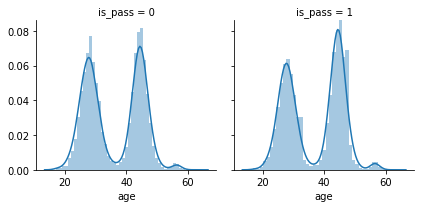

In [24]:
g = sns.FacetGrid(dataset, col='is_pass')
g = g.map(sns.distplot, "age")

In [25]:
dataset['age_given']=dataset['age'].apply(lambda x:0 if math.isnan(x) == True else 1)

is_pass  city_tier
0        1             6185
         2             4939
         3             8289
         4             2867
1        1            16954
         2            11361
         3            17932
         4             4620
Name: is_pass, dtype: int64


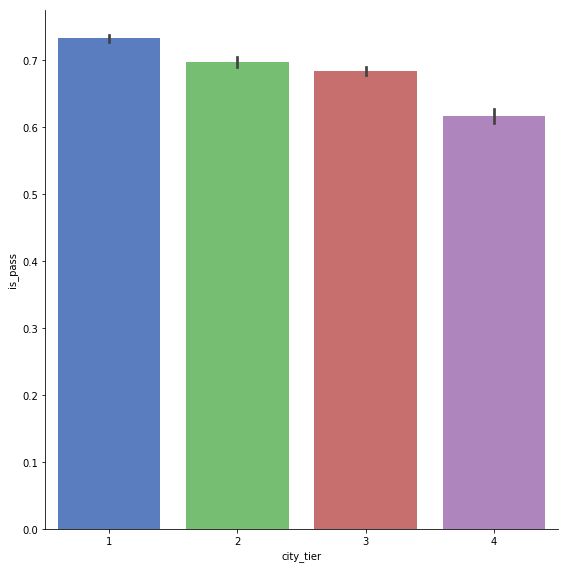

In [26]:
print(train.groupby(['is_pass', 'city_tier'])['is_pass'].count())
g = sns.factorplot(x='city_tier',y='is_pass', data=train, kind='bar', size = 8 , palette = 'muted')

In [27]:
dummy_city_tier=pd.get_dummies(dataset['city_tier'])
dataset=pd.concat([dataset, dummy_city_tier], axis=1)

In [28]:
grouped_df_trainee=dataset.groupby('trainee_id').agg('size').reset_index()
grouped_df_trainee. columns= ['trainee_id', 'times_test_taken']
dataset=dataset.merge(dataset.merge(grouped_df_trainee, on='trainee_id', sort=False))

In [29]:
grouped_df_test=dataset.groupby(['trainee_id','test_id']).agg('size').reset_index().drop_duplicates(subset=['trainee_id'], keep='first')
grouped_df_test.columns=['trainee_id', 'test_id', 'first_attempt']
dataset=dataset.merge(dataset.merge(grouped_df_test, on=['trainee_id' , 'test_id'], sort=False, how='left'))
dataset['first_attempt']=dataset['first_attempt'].fillna(0)

In [30]:
dataset['time_per_program']= dataset['program_duration'] / dataset['total_programs_enrolled']

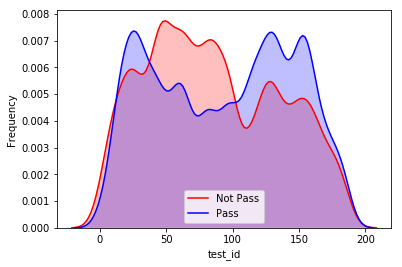

In [31]:
g = sns.kdeplot(train["test_id"][(train["is_pass"] == 0) & (train["test_id"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["test_id"][(train["is_pass"] == 1) & (train["test_id"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("test_id")
g.set_ylabel("Frequency")
g = g.legend(["Not Pass","Pass"])

In [32]:
dataset.loc[ dataset['test_id'] <= 32, 'test_id_range']= 1
dataset.loc[(dataset['test_id'] > 32) & (dataset['test_id'] <= 100), 'test_id_range'] = 0
dataset.loc[(dataset['test_id'] > 100) , 'test_id_range'] = 1

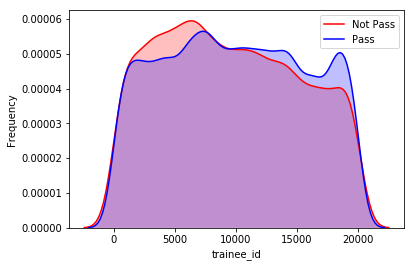

In [33]:
g = sns.kdeplot(train["trainee_id"][(train["is_pass"] == 0) & (train["trainee_id"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["trainee_id"][(train["is_pass"] == 1) & (train["trainee_id"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("trainee_id")
g.set_ylabel("Frequency")
g = g.legend(["Not Pass","Pass"])

In [34]:
dataset['trainee_id_range']=dataset['trainee_id']. apply(lambda x: 0 if x<8500 else 1)

In [35]:
dataset['new_program_id'] = [x[-1] for x in dataset.program_id ]
dataset['new_program_id'] = dataset['new_program_id'].astype(int)

In [36]:
dataset.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,...,1,2,3,4,times_test_taken,first_attempt,time_per_program,test_id_range,trainee_id_range,new_program_id
0,9389_150,Y_1,Y,136,150,offline,2,9389,1,2,...,0,0,1,0,5,0.0,27.20,1.0,1,1
1,16523_44,T_1,T,131,44,offline,1,16523,0,3,...,0,0,0,1,2,1.0,65.50,0.0,1,1
2,13987_178,Z_2,Z,120,178,online,1,13987,1,2,...,1,0,0,0,5,0.0,120.00,1.0,1,2
3,13158_32,T_2,T,117,32,offline,1,13158,0,2,...,0,0,1,0,5,1.0,29.25,1.0,1,2
4,10591_84,V_3,V,131,84,offline,2,10591,0,3,...,1,0,0,0,3,1.0,65.50,0.0,1,3


In [37]:
dataset=dataset.drop(['id', 'program_id', 'program_type', 'city_tier','test_type'], axis=1)

In [38]:
dataset.head()

,program_duration,test_id,difficulty_level,trainee_id,gender,education,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,...,1,2,3,4,times_test_taken,first_attempt,time_per_program,test_id_range,trainee_id_range,new_program_id
0,136,150,2,9389,1,2,24.0,5,0,1.0,...,0,0,1,0,5,0.0,27.20,1.0,1,1
1,131,44,1,16523,0,3,26.0,2,0,3.0,...,0,0,0,1,2,1.0,65.50,0.0,1,1
2,120,178,1,13987,1,2,40.0,1,0,2.0,...,1,0,0,0,5,0.0,120.00,1.0,1,2
3,117,32,1,13158,0,2,NaN,4,0,1.0,...,0,0,1,0,5,1.0,29.25,1.0,1,2
4,131,84,2,10591,0,3,42.0,2,0,4.0,...,1,0,0,0,3,1.0,65.50,0.0,1,3


In [39]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
y=dataset['is_pass']
X=dataset.drop(['is_pass'], axis=1)

dataset_predict_age=X.copy().drop(['test_id', 'difficulty_level'], axis=1)
dataset_predict_age.dropna(inplace=True)
y_age=dataset_predict_age['age'].values
X_age=dataset_predict_age.drop(['age'], axis=1)
orig_age=X['age']
X=X.drop(['age'],axis=1)
X_age=X_age.values
sc_X=StandardScaler()
sc_X.fit_transform(X_age)
X_age_train, X_age_test, y_age_train, y_age_test= train_test_split(X_age, y_age, test_size=0.1, random_state=0)
train_data = lgb.Dataset(X_age_train, label=y_age_train)
test_data = lgb.Dataset(X_age_test, label=y_age_test)

parameters = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting': 'gbdt',
    'verbose': 1,
    'learning_rate': 0.1,
    'n_estimators':500,
    'num_leaves': 1000,
    'random_state': 0
}

model = lgb.train(parameters,
                    train_data,
                    valid_sets=test_data,
                    num_boost_round=1000,
                    early_stopping_rounds=50)

y_pred_age=model.predict(X.drop(['test_id', 'difficulty_level'], axis=1))

c:\users\anirudh prakash\appdata\local\programs\python\python35\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 74.4993
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 68.7598
[3]	valid_0's l2: 63.9762
[4]	valid_0's l2: 59.7953
[5]	valid_0's l2: 56.3119
[6]	valid_0's l2: 53.1541
[7]	valid_0's l2: 50.3476
[8]	valid_0's l2: 47.8221
[9]	valid_0's l2: 45.6743
[10]	valid_0's l2: 43.7002
[11]	valid_0's l2: 42.0525
[12]	valid_0's l2: 40.4409
[13]	valid_0's l2: 38.9499
[14]	valid_0's l2: 37.5935
[15]	valid_0's l2: 36.2001
[16]	valid_0's l2: 34.9594
[17]	valid_0's l2: 33.8294
[18]	valid_0's l2: 32.7242
[19]	valid_0's l2: 31.7714
[20]	valid_0's l2: 30.8325
[21]	valid_0's l2: 30.0019
[22]	valid_0's l2: 29.1083
[23]	valid_0's l2: 28.2493
[24]	valid_0's l2: 27.5607
[25]	valid_0's l2: 26.9349
[26]	valid_0's l2: 26.2209
[27]	valid_0's l2: 25.5195
[28]	valid_0's l2: 24.9031
[29]	valid_0's l2: 24.2886
[30]	valid_0's l2: 23.7397
[31]	valid_0's l2: 23.2863
[32]	valid_0's l2: 22.733
[33]	valid_0's l2: 22.2265
[34]	valid_0's l2: 21.8161
[35]	valid_0's l2: 21.3766
[36

[296]	valid_0's l2: 6.47419
[297]	valid_0's l2: 6.46742
[298]	valid_0's l2: 6.46388
[299]	valid_0's l2: 6.46016
[300]	valid_0's l2: 6.45753
[301]	valid_0's l2: 6.45695
[302]	valid_0's l2: 6.45452
[303]	valid_0's l2: 6.45162
[304]	valid_0's l2: 6.4484
[305]	valid_0's l2: 6.44129
[306]	valid_0's l2: 6.4391
[307]	valid_0's l2: 6.43646
[308]	valid_0's l2: 6.43278
[309]	valid_0's l2: 6.42911
[310]	valid_0's l2: 6.42319
[311]	valid_0's l2: 6.42135
[312]	valid_0's l2: 6.41889
[313]	valid_0's l2: 6.41538
[314]	valid_0's l2: 6.41259
[315]	valid_0's l2: 6.41035
[316]	valid_0's l2: 6.40857
[317]	valid_0's l2: 6.40533
[318]	valid_0's l2: 6.40056
[319]	valid_0's l2: 6.39763
[320]	valid_0's l2: 6.39452
[321]	valid_0's l2: 6.39267
[322]	valid_0's l2: 6.39236
[323]	valid_0's l2: 6.3893
[324]	valid_0's l2: 6.38822
[325]	valid_0's l2: 6.3838
[326]	valid_0's l2: 6.37694
[327]	valid_0's l2: 6.37521
[328]	valid_0's l2: 6.37192
[329]	valid_0's l2: 6.37038
[330]	valid_0's l2: 6.36648
[331]	valid_0's l2: 6.36

In [40]:
age_predicted=pd.DataFrame(data=y_pred_age, columns=['Age'])
age_predicted.head()
orig_age.fillna(age_predicted.Age, inplace=True)
X=pd.concat([X,orig_age] , axis=1)
cleaned_dataset=pd.concat([X,y], axis=1)

In [41]:
cleaned_dataset['age_40']=cleaned_dataset['age'].apply(lambda x: 0 if x<40 else 1)

In [42]:
cleaned_dataset.head()

,program_duration,test_id,difficulty_level,trainee_id,gender,education,total_programs_enrolled,is_handicapped,trainee_engagement_rating,rating_given,...,4,times_test_taken,first_attempt,time_per_program,test_id_range,trainee_id_range,new_program_id,age,is_pass,age_40
0,136,150,2,9389,1,2,5,0,1.0,1,...,0,5,0.0,27.20,1.0,1,1,24.000000,0,0
1,131,44,1,16523,0,3,2,0,3.0,1,...,1,2,1.0,65.50,0.0,1,1,26.000000,1,0
2,120,178,1,13987,1,2,1,0,2.0,1,...,0,5,0.0,120.00,1.0,1,2,40.000000,1,1
3,117,32,1,13158,0,2,4,0,1.0,1,...,0,5,1.0,29.25,1.0,1,2,29.491087,1,0
4,131,84,2,10591,0,3,2,0,4.0,1,...,0,3,1.0,65.50,0.0,1,3,42.000000,1,1


In [43]:
cleaned_dataset.to_csv('Cleaned_Dataset.csv', index=False)

In [44]:
cleaned_dataset.corr(method='pearson', min_periods=1000)

,program_duration,test_id,difficulty_level,trainee_id,gender,education,total_programs_enrolled,is_handicapped,trainee_engagement_rating,rating_given,...,4,times_test_taken,first_attempt,time_per_program,test_id_range,trainee_id_range,new_program_id,age,is_pass,age_40
program_duration,1.000000,0.203368,0.096353,0.149458,0.113462,0.010565,-0.005856,-0.007946,0.097401,-0.013455,...,-0.019090,-0.083122,0.023150,0.127717,0.161901,0.213207,-0.415002,-0.033851,0.002184,-0.026240
test_id,0.203368,1.000000,-0.033901,0.148954,0.284510,-0.080073,-0.134765,0.028823,0.326485,0.015387,...,-0.001289,0.109144,-0.074683,0.318219,0.386074,0.189386,-0.214490,-0.030513,0.050774,-0.031025
difficulty_level,0.096353,-0.033901,1.000000,0.021472,0.138804,0.059366,0.055293,-0.029937,0.095689,0.004795,...,-0.023625,-0.068511,-0.114099,-0.128078,-0.075525,0.018379,-0.095100,-0.040896,-0.072689,-0.041513
trainee_id,0.149458,0.148954,0.021472,1.000000,0.022691,0.015898,-0.074000,-0.015527,0.030465,0.018269,...,-0.003983,-0.052699,0.016917,0.103847,-0.041646,0.849598,-0.344595,0.089986,0.022600,0.102270
gender,0.113462,0.284510,0.138804,0.022691,1.000000,0.074715,0.060388,-0.046631,0.266288,0.002237,...,-0.048457,0.132258,-0.010296,-0.119518,0.020861,0.020346,-0.082581,-0.037948,0.011320,-0.052864
education,0.010565,-0.080073,0.059366,0.015898,0.074715,1.000000,0.046037,-0.079792,0.060048,0.002238,...,-0.078414,0.078580,-0.020008,-0.082407,-0.104967,0.003302,-0.023760,0.094861,0.052618,0.085389
total_programs_enrolled,-0.005856,-0.134765,0.055293,-0.074000,0.060388,0.046037,1.000000,0.032049,0.082821,-0.004013,...,0.010078,0.092295,-0.010124,-0.809410,-0.023630,-0.090765,0.073027,-0.084993,-0.022269,-0.098973
is_handicapped,-0.007946,0.028823,-0.029937,-0.015527,-0.046631,-0.079792,0.032049,1.000000,-0.031673,-0.003608,...,0.043054,-0.001715,0.005712,0.001279,0.008791,-0.027150,0.006066,-0.028486,-0.019499,-0.036933
trainee_engagement_rating,0.097401,0.326485,0.095689,0.030465,0.266288,0.060048,0.082821,-0.031673,1.000000,0.033841,...,-0.032737,0.314698,-0.110485,-0.159097,0.232803,-0.001323,0.018645,0.184665,0.125605,0.167136
rating_given,-0.013455,0.015387,0.004795,0.018269,0.002237,0.002238,-0.004013,-0.003608,0.033841,1.000000,...,0.004974,0.012192,0.001587,0.005916,0.006740,0.015211,0.004608,0.001008,0.008683,0.000566


In [45]:
cleaned_dataset.describe()

,program_duration,test_id,difficulty_level,trainee_id,gender,education,total_programs_enrolled,is_handicapped,trainee_engagement_rating,rating_given,...,4,times_test_taken,first_attempt,time_per_program,test_id_range,trainee_id_range,new_program_id,age,is_pass,age_40
count,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,...,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000,104496.000000
mean,128.209386,90.937672,1.650781,9846.168045,0.534690,2.800873,2.586223,0.088511,2.396331,0.998966,...,0.102444,7.180179,0.185864,60.223441,0.620215,0.558883,2.361516,36.061011,0.486784,0.397498
std,6.892792,51.219793,0.825037,5706.697072,0.498798,0.731030,1.238415,0.284037,1.327204,0.032132,...,0.303233,3.113487,0.388998,27.476597,0.485336,0.496523,1.101691,7.924235,0.499828,0.489383
min,117.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,8.714286,0.000000,0.000000,1.000000,15.752640,0.000000,0.000000
25%,121.000000,45.000000,1.000000,5041.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000,...,0.000000,5.000000,0.000000,40.000000,0.000000,0.000000,1.000000,29.000000,0.000000,0.000000
50%,131.000000,90.000000,1.000000,9648.500000,1.000000,3.000000,2.000000,0.000000,2.000000,1.000000,...,0.000000,7.000000,0.000000,60.500000,1.000000,1.000000,2.000000,35.461887,0.000000,0.000000
75%,134.000000,135.000000,2.000000,14555.250000,1.000000,3.000000,3.000000,0.000000,4.000000,1.000000,...,0.000000,9.000000,0.000000,67.000000,1.000000,1.000000,3.000000,43.163417,1.000000,1.000000
max,136.000000,187.000000,4.000000,20098.000000,1.000000,5.000000,14.000000,1.000000,5.000000,1.000000,...,1.000000,23.000000,1.000000,136.000000,1.000000,1.000000,4.000000,63.000000,1.000000,1.000000
